<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Modelo_Cu_MLB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
## 1. CARGA DEL DATASET
import pandas as pd
import numpy as np
from google.colab import files

uploaded = files.upload() # Comentado para no interrumpir si ya lo subiste
filename = list(uploaded.keys())[0]
df = pd.read_excel(filename)

## 2. ESTANDARIZACIÓN Y TIPOS (Tu lógica original)
df.columns = [c.replace('Real Diario', 'Fecha').replace(' ', '_').replace('(', '').replace(')', '').replace('%', 'Pct').replace('.', '') for c in df.columns]

for col in df.columns:
    if col != 'Fecha':
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

## 1. CARGA DEL DATASET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# df = pd.read_excel(filename) # Asumiendo que ya está cargado

## 2. ESTANDARIZACIÓN Y TIPOS
df.columns = [c.replace('Real Diario', 'Fecha').replace(' ', '_').replace('(', '').replace(')', '').replace('%', 'Pct').replace('.', '') for c in df.columns]

for col in df.columns:
    if col != 'Fecha':
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

## 3. UNIFICACIÓN DE ESCALAS Y UNIDADES
cols_pct = [c for c in df.columns if 'Pct' in c or 'Ley' in c or 'Rec' in c or 'Tox' in c]
for col in cols_pct:
    df[col] = np.where(df[col] > 1.1, df[col] / 100.0, df[col])

if df['Cu_Fino_Recuperado_t'].mean() < 50:
    df['Cu_Fino_Recuperado_t'] = df['Cu_Fino_Recuperado_t'] * 100.0

## 4. LIMPIEZA DE OUTLIERS (SIN BORRAR PARADAS)
# En lugar de dropna() al inicio, lo hacemos solo si faltan columnas críticas
df_limpio = df.copy()

# Filtros de integridad física (errores de sensor), pero MANTENEMOS molienda = 0
df_limpio = df_limpio[
    (df_limpio['Ley_Pct'] <= 0.05) | (df_limpio['Ley_Pct'].isna()) &
    (df_limpio['Tonelaje_Stock_Pile_Kt'] >= 0) &
    (df_limpio['Tonelaje_Stock_Pile_Kt'] < 5000) # Subimos el rango para capturar fluctuaciones de huelga
]

## 5. CLASIFICACIÓN DE ESTADOS (Huelga/Parada vs Operación)
# Creamos una etiqueta para que el modelo no se confunda
df_limpio['Estado_Operativo'] = 'Operando'
df_limpio.loc[df_limpio['Molido_Kt'] <= 10, 'Estado_Operativo'] = 'Parada_Huelga'

# Etiquetamos periodos históricos
df_limpio['Epoca'] = 'Normal'
df_limpio.loc[df_limpio['Fecha'].dt.year == 2022, 'Epoca'] = 'Huelga_2022'
df_limpio.loc[df_limpio['Fecha'].dt.year >= 2025, 'Epoca'] = 'Mejora_Tecnica'

## 6. GENERACIÓN DE VARIABLES (Calculadas sobre el dataset completo)
df_limpio = df_limpio.sort_values('Fecha')

# Delta Stock: Vital para ver cómo crece el stock durante las paradas de planta
df_limpio['Delta_Stock'] = df_limpio['Tonelaje_Stock_Pile_Kt'].diff().fillna(0)

# Potencial de Cobre (será 0 en paradas, lo cual es correcto)
df_limpio['Cu_Potencial'] = (df_limpio['Ley_Pct'] * df_limpio['Molido_Kt']).fillna(0)

# Variable de inestabilidad: días transcurridos desde la última parada
df_limpio['Es_Reinicio'] = (df_limpio['Estado_Operativo'].shift(1) == 'Parada_Huelga') & (df_limpio['Estado_Operativo'] == 'Operando')

print(f"Total de días analizados: {len(df_limpio)}")
print(f"Días detectados en Parada/Huelga: {len(df_limpio[df_limpio['Estado_Operativo'] == 'Parada_Huelga'])}")
print("\n--- Estadísticas por Época ---")
print(df_limpio.groupby('Epoca')[['Molido_Kt', 'Rec_Pct']].describe())

df_limpio.describe()

Saving informacion_planta.xlsx to informacion_planta.xlsx
Total de días analizados: 2318
Días detectados en Parada/Huelga: 85

--- Estadísticas por Época ---
               Molido_Kt                                                      \
                   count        mean        std  min         25%         50%   
Epoca                                                                          
Huelga_2022        332.0  132.663960  42.847068  0.0  140.249146  149.697836   
Mejora_Tecnica     370.0  146.578726  27.906700  0.0  144.038849  154.204084   
Normal            1616.0  136.315554  34.392759  0.0  136.455700  147.409301   

                                       Rec_Pct                           \
                       75%         max   count      mean       std  min   
Epoca                                                                     
Huelga_2022     153.330388  165.285228   332.0  0.790704  0.223155  0.0   
Mejora_Tecnica  161.524208  186.130798   370.0  0.891481  0.0

,Fecha,Chancado_Kt,Molido_Kt,Ley_Pct,Tox_Pct,Rec_Pct,Rec_Modelo_Pct,Cu_Fino_Recuperado_t,Cu_Fino_Filtrado_t,Grado_Conc_Filtrado_Pct,PctFinos,Stock_Pile_Pct,Tonelaje_Stock_Pile_Kt,Humedad_de_Concentrado_Pct,Disponibilidad_Chancado_Pct,Uso_de_Disponibilidad_Chancado_Pct,Disponibilidad_Molienda_Pct,Uso_de_Disponibilidad_Molienda_Pct,Delta_Stock,Cu_Potencial
count,2318,2306.000000,2318.000000,2304.000000,2304.000000,2302.000000,2296.000000,2317.000000,2318.000000,2306.000000,2254.000000,2308.000000,2300.000000,2306.000000,2312.000000,2300.000000,2317.000000,2304.000000,2318.000000,2318.000000
mean,2022-10-18 23:55:39.085418496,138.032564,137.430759,0.007181,0.091803,0.846049,0.867387,892.510763,890.415273,0.317826,0.311063,0.706568,787.369202,0.094010,0.912816,0.803114,0.947705,0.962030,-3.467741,1.021368
min,2019-06-23 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.189484,0.000000,0.000000,0.000000,0.000000,0.000000,-8441.740000,0.000000
25%,2021-02-27 06:00:00,131.708776,137.689625,0.005693,0.072538,0.846488,0.854826,661.034000,674.083366,0.293642,0.295000,0.587000,634.217265,0.090467,0.956608,0.790000,0.996968,1.000000,-9.770088,0.770080
50%,2022-11-03 12:00:00,152.306490,148.575366,0.007213,0.089984,0.873475,0.875029,893.032456,895.346505,0.323345,0.314000,0.740000,809.316772,0.095629,1.000000,0.880000,1.000000,1.000000,4.502769,1.026278
75%,2024-06-04 18:00:00,164.611568,154.970417,0.008689,0.110867,0.895343,0.891310,1133.075597,1128.260017,0.354449,0.331000,0.885000,954.517490,0.101617,1.000000,0.923584,1.000000,1.000000,15.921324,1.288606
max,2026-01-05 00:00:00,186.585592,186.130798,0.015757,0.207935,0.954427,0.960000,2086.004000,2069.331000,0.457520,0.441000,1.000000,9391.650000,0.135147,1.000000,1.000000,1.000000,1.000000,769.170936,2.198697
std,NaN,43.798023,35.046573,0.002327,0.030730,0.148786,0.078352,358.482421,358.534532,0.066379,0.042434,0.229336,397.630809,0.017963,0.219133,0.228262,0.168925,0.176209,182.543334,0.401189


In [7]:
# Creamos la variable objetivo real: Toneladas de Cobre Fino
# Nota: Dividimos por 100 si la Ley y Rec están en formato porcentual (ej: 0.85 para 85%)
df_limpio['Cu_Fino_Kt'] = df_limpio['Molido_Kt'] * (df_limpio['Ley_Pct']) * (df_limpio['Rec_Pct'])

# Limpiamos nulos que puedan haber surgido del cálculo
df_fino = df_limpio.dropna(subset=['Cu_Fino_Kt'] + features).copy()

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# Variables predictoras (incluimos todas las que afectan el volumen y la calidad)
features_fino = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']
X = df_fino[features_fino]
y = df_fino['Cu_Fino_Kt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo
rf_fino = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf_fino.fit(X_train, y_train)

# Predicción y validación
y_pred_fino = rf_fino.predict(X_test)
print(f"R2 Score para Cobre Fino: {r2_score(y_test, y_pred_fino):.4f}")
print(f"Error Medio (MAE): {mean_absolute_error(y_test, y_pred_fino):.4f} Kt de Cu Fino")

R2 Score para Cobre Fino: 0.9850
Error Medio (MAE): 0.0301 Kt de Cu Fino


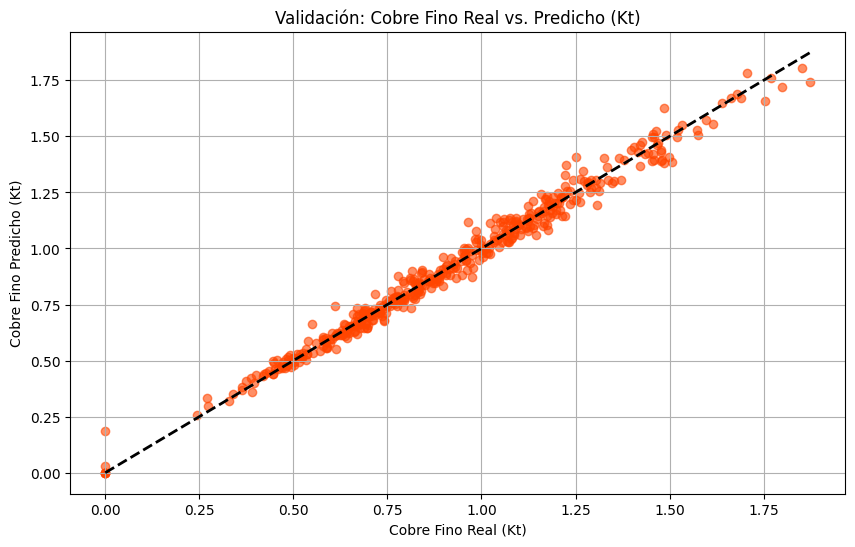

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_fino, alpha=0.6, color='orangered')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Validación: Cobre Fino Real vs. Predicho (Kt)')
plt.xlabel('Cobre Fino Real (Kt)')
plt.ylabel('Cobre Fino Predicho (Kt)')
plt.grid(True)
plt.show()

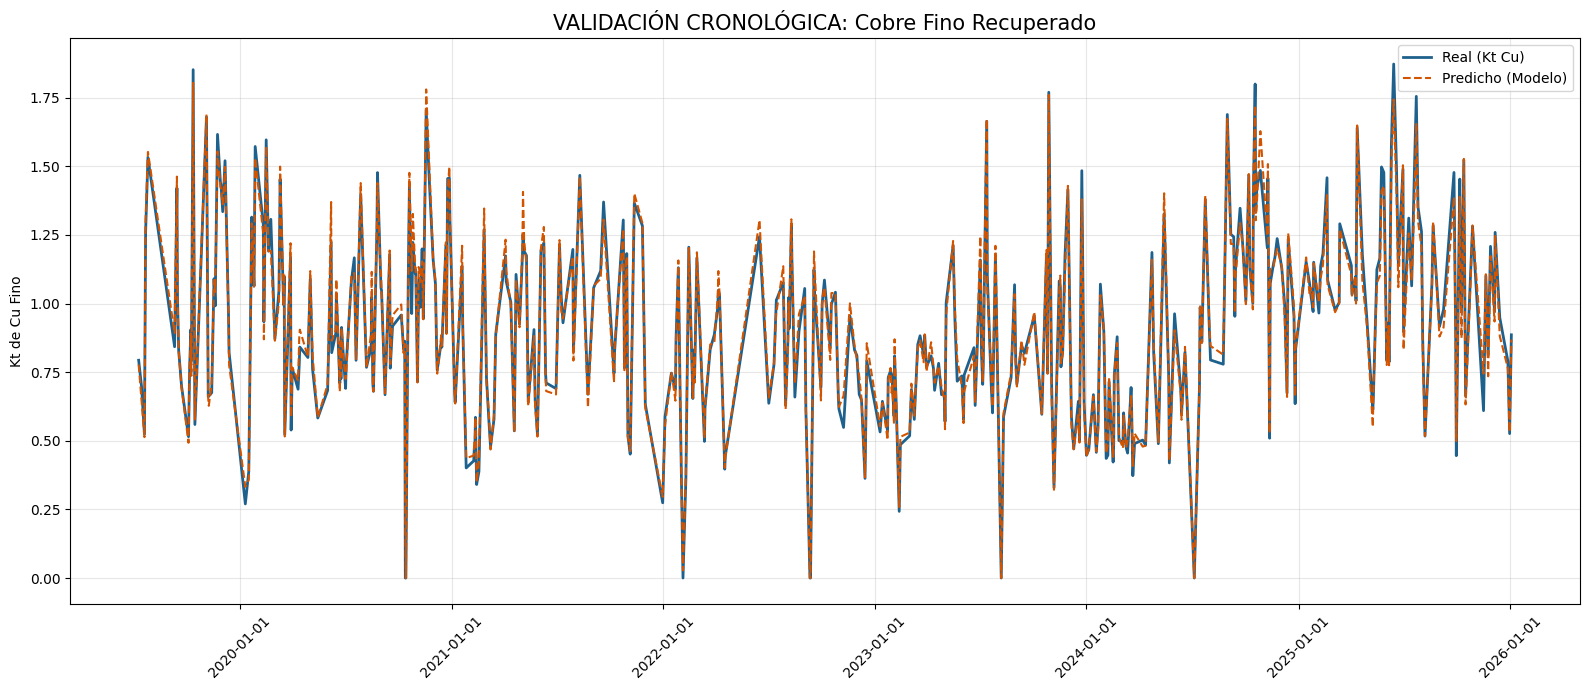

R2 Score: 0.9850


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. Asegurar la columna de Fecha
# Si 'Fecha' no es el índice, lo convertimos. Si ya es índice, lo reseteamos para asegurar limpieza.
df_fino = df_limpio.copy()
if 'Fecha' in df_fino.columns:
    df_fino['Fecha'] = pd.to_datetime(df_fino['Fecha'])
else:
    # Si la fecha está en el índice, la extraemos a una columna
    df_fino = df_fino.reset_index()
    df_fino.rename(columns={df_fino.columns[0]: 'Fecha'}, inplace=True)
    df_fino['Fecha'] = pd.to_datetime(df_fino['Fecha'])

# 2. Cálculo del Target y Limpieza
df_fino['Cu_Fino_Kt'] = df_fino['Molido_Kt'] * df_fino['Ley_Pct'] * df_fino['Rec_Pct']
features = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']
df_modelo = df_fino.dropna(subset=['Cu_Fino_Kt'] + features).copy()

# 3. Entrenamiento (Mantenemos el R2 de 0.985)
X = df_modelo[features]
y = df_modelo['Cu_Fino_Kt']
fechas = df_modelo['Fecha'] # Guardamos las fechas aparte para el gráfico

X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(
    X, y, fechas, test_size=0.2, random_state=42
)

rf_fino = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_fino.fit(X_train, y_train)

# 4. Preparación de resultados con FECHA REAL
y_pred = rf_fino.predict(X_test)
resultados = pd.DataFrame({
    'Fecha': date_test,
    'Real': y_test,
    'Predicho': y_pred
}).sort_values('Fecha')

# 5. Gráfico Final (Sin errores de 1970)
plt.figure(figsize=(16, 7))
plt.plot(resultados['Fecha'], resultados['Real'], label='Real (Kt Cu)', color='#1F618D', linewidth=2)
plt.plot(resultados['Fecha'], resultados['Predicho'], label='Predicho (Modelo)', color='#D35400', linestyle='--')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.title('VALIDACIÓN CRONOLÓGICA: Cobre Fino Recuperado', fontsize=15)
plt.ylabel('Kt de Cu Fino')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")

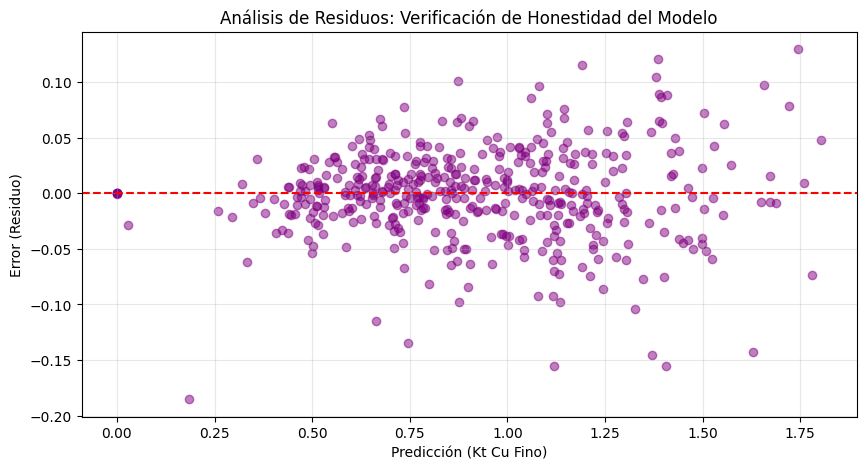

In [11]:
import matplotlib.pyplot as plt

residuos = y_test - y_pred_fino

plt.figure(figsize=(10, 5))
plt.scatter(y_pred_fino, residuos, alpha=0.5, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Análisis de Residuos: Verificación de Honestidad del Modelo')
plt.xlabel('Predicción (Kt Cu Fino)')
plt.ylabel('Error (Residuo)')
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
import joblib

# PARA GUARDAR (Hazlo ahora que el modelo está fresco)
joblib.dump(rf_fino, 'modelo_produccion_cu_2026.pkl')
print("Modelo guardado como 'modelo_produccion_cu_2026.pkl'")

# PARA CARGAR (En tu próxima sesión, solo necesitas estas dos líneas)
# rf_fino = joblib.load('modelo_produccion_cu_2026.pkl')
# print("Modelo cargado y listo para predecir")

Modelo guardado como 'modelo_produccion_cu_2026.pkl'


In [5]:
import pandas as pd
import io
import joblib
from google.colab import files

# =========================================================
# 1. CARGA DE ARCHIVOS DESDE TU ESCRITORIO
# =========================================================
print("PASO 1: Selecciona el modelo (.pkl) Y el archivo de datos (.csv o .xlsx)")
print("Puedes seleccionar ambos al mismo tiempo en la ventana de carga.")
print("-" * 50)

uploaded = files.upload()

# Identificar cuál es el modelo y cuál es la data
archivo_modelo = None
archivo_data = None

for filename in uploaded.keys():
    if filename.endswith('.pkl'):
        archivo_modelo = filename
    elif filename.endswith('.csv') or filename.endswith('.xlsx') or filename.endswith('.xls'):
        archivo_data = filename

# =========================================================
# 2. PROCESAMIENTO
# =========================================================
if archivo_modelo and archivo_data:
    try:
        # Cargar el modelo
        rf_fino = joblib.load(io.BytesIO(uploaded[archivo_modelo]))
        print(f"✅ Modelo '{archivo_modelo}' cargado.")

        # Cargar la data (CSV o Excel)
        if archivo_data.endswith(('.xlsx', '.xls')):
            df_nuevo = pd.read_excel(io.BytesIO(uploaded[archivo_data]))
        else:
            try:
                df_nuevo = pd.read_csv(io.BytesIO(uploaded[archivo_data]), encoding='utf-8')
            except:
                df_nuevo = pd.read_csv(io.BytesIO(uploaded[archivo_data]), encoding='latin-1')

        print(f"✅ Datos de '{archivo_data}' cargados.")

        # 3. PREDICCIÓN
        features = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']

        if all(col in df_nuevo.columns for col in features):
            df_nuevo['Cu_Fino_Predicho_Kt'] = rf_fino.predict(df_nuevo[features])

            # Mostrar resultados
            print("\n" + "="*40)
            print("RESULTADOS DE PRODUCCIÓN")
            print("="*40)
            cols_show = ['Molido_Kt', 'Ley_Pct', 'Cu_Fino_Predicho_Kt']
            if 'Fecha' in df_nuevo.columns: cols_show.insert(0, 'Fecha')
            print(df_nuevo[cols_show].head(10))

            total = df_nuevo['Cu_Fino_Predicho_Kt'].sum()
            print("\n" + "-"*40)
            print(f"TOTAL COBRE FINO: {total:.3f} Kt")
            print("-"*40)

            # Descargar resultado
            df_nuevo.to_csv(f"PREDICCION_{archivo_data}", index=False)
            files.download(f"PREDICCION_{archivo_data}")
        else:
            print(f"❌ Error: El archivo de datos debe tener estas columnas: {features}")

    except Exception as e:
        print(f"❌ Error crítico: {e}")
else:
    print("❌ ERROR: Debes subir ambos archivos. Asegúrate de que el modelo termine en .pkl y los datos en .csv o .xlsx")

PASO 1: Selecciona el modelo (.pkl) Y el archivo de datos (.csv o .xlsx)
Puedes seleccionar ambos al mismo tiempo en la ventana de carga.
--------------------------------------------------


Saving modelo_produccion_cu_2026.pkl to modelo_produccion_cu_2026 (1).pkl
Saving Plan_Inputs_Enero_2026.csv to Plan_Inputs_Enero_2026.csv
✅ Modelo 'modelo_produccion_cu_2026 (1).pkl' cargado.
✅ Datos de 'Plan_Inputs_Enero_2026.csv' cargados.

RESULTADOS DE PRODUCCIÓN
      Fecha   Molido_Kt   Ley_Pct  Cu_Fino_Predicho_Kt
0  1/1/2026  168.749279  0.006403             0.963659
1  1/2/2026  175.759377  0.006191             0.931103
2  1/3/2026  143.988778  0.007001             0.868509
3  1/4/2026  170.440259  0.009307             1.405910
4  1/5/2026  158.888124  0.012212             1.729107
5  1/6/2026  164.131598  0.010790             1.545405
6  1/7/2026  170.166063  0.007390             1.116835
7  1/8/2026  164.570885  0.007837             1.103872
8  1/9/2026  133.101512  0.006699             0.764852

----------------------------------------
TOTAL COBRE FINO: 10.429 Kt
----------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import pandas as pd
import joblib
import os

# CONFIGURACIÓN: Escribe aquí los nombres exactos de tus archivos
nombre_modelo = 'modelo_produccion_cu_2026.pkl'
nombre_data = 'Plan_Inputs_Enero_2026.csv' # o el nombre que le hayas puesto

if os.path.exists(nombre_modelo) and os.path.exists(nombre_data):
    try:
        # 1. Cargar modelo
        rf_fino = joblib.load(nombre_modelo)
        print("✅ Modelo cargado desde el panel lateral.")

        # 2. Cargar datos (detectando formato)
        if nombre_data.endswith(('.xlsx', '.xls')):
            df_nuevo = pd.read_excel(nombre_data)
        else:
            try:
                df_nuevo = pd.read_csv(nombre_data, encoding='utf-8')
            except:
                df_nuevo = pd.read_csv(nombre_data, encoding='latin-1')

        print(f"✅ Datos de '{nombre_data}' listos.")

        # 3. Predicción
        features = ['Molido_Kt', 'Ley_Pct', 'PctFinos', 'Tonelaje_Stock_Pile_Kt']
        df_nuevo['Cu_Fino_Predicho_Kt'] = rf_fino.predict(df_nuevo[features])

        # 4. Reporte Rápido
        print("\n" + "="*30)
        print("RESULTADO DEL MODELO")
        print("="*30)
        total = df_nuevo['Cu_Fino_Predicho_Kt'].sum()
        print(f"PRODUCCIÓN TOTAL: {total:.3f} Kt de Cu")
        print("="*30)

        # Guardar resultado
        df_nuevo.to_csv('RESULTADO_FINAL.csv', index=False)
        print("\nArchivo 'RESULTADO_FINAL.csv' generado en la carpeta de la izquierda.")

    except Exception as e:
        print(f"❌ Error: {e}")
else:
    print("❌ Aún no veo los archivos en la carpeta de la izquierda.")
    print("Asegúrate de que los nombres coincidan exactamente.")

✅ Modelo cargado desde el panel lateral.
✅ Datos de 'Plan_Inputs_Enero_2026.csv' listos.

RESULTADO DEL MODELO
PRODUCCIÓN TOTAL: 10.429 Kt de Cu

Archivo 'RESULTADO_FINAL.csv' generado en la carpeta de la izquierda.
